### cifar10数据集下载

In [ ]:
# 创建文件夹
# !mkdir -p  /home/aistudio/.cache/paddle/dataset/cifar/ 
# 下载数据集
# !wget "http://ai-atest.bj.bcebos.com/cifar-10-python.tar.gz" -O cifar-10-python.tar.gz
# 移动
# !mv cifar-10-python.tar.gz  /home/aistudio/.cache/paddle/dataset/cifar/
# 查看
# !ls -a /home/aistudio/.cache/paddle/dataset/cifar/

### 导入相关库

In [29]:
import warnings
warnings.filterwarnings('ignore')

import paddle
import numpy as np
import matplotlib.pyplot as plt
from paddle.static import InputSpec
from paddle.regularizer import L2Decay

### 定义网络结构， 使用模型为resnet20

In [30]:
import paddle
from paddle import nn
from paddle.vision.models.resnet import BasicBlock


class ResNet(nn.Layer):
    def __init__(self, block, depth, num_classes=10):
        super(ResNet, self).__init__()
        layer_cfg = {
            20: [3, 3, 3],
            32: [5, 5, 5],
            44: [7, 7, 7],
            56: [9, 9, 9],
            110:[18, 18, 18],
            1202:[200, 200, 200],
        }
        layers = layer_cfg[depth]
        self.num_classes = num_classes
        self._norm_layer = nn.BatchNorm2D

        self.inplanes = 16
        self.dilation = 1

        self.conv1 = nn.Conv2D(
            3,
            self.inplanes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias_attr=False)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2D((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(
                    self.inplanes,
                    planes * block.expansion,
                    1,
                    stride=stride,
                    bias_attr=False),
                norm_layer(planes * block.expansion), )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, 1, 16,
                  previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    # @paddle.jit.to_static(input_spec=[paddle.static.InputSpec(shape=[None, 3, 32, 32], name='x')])
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = paddle.flatten(x, 1)
        x = self.fc(x)

        return x

### 数据处理 读取cifar10数据，采用数据增强手段

In [31]:
place = paddle.CUDAPlace(0)
BATCH_SIZE = 512

In [33]:
# 数据读取和数据增强
import paddle
import paddle.vision.transforms  as T
from paddle.io import Dataset, BatchSampler, DataLoader

# 使用transform对数据集做归一化
print('download training data and load training data')
#数据增强
transform1=T.Compose(
    [
        T.RandomCrop(32, padding=4),# 按0.5的概率随机裁剪图片
        T.RandomHorizontalFlip(0.5), # 按0.5的概率水平反转图片
        T.Transpose(), # 格式转换
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # 归一化
    ]
)
transform2=T.Compose(
    [
        T.Transpose(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),# 归一化处理
    ]
)

train_data = paddle.vision.datasets.cifar.Cifar10("./cifar-10-python.tar.gz", mode="train", transform=transform1)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,
                 use_shared_memory=False)

test_data = paddle.vision.datasets.cifar.Cifar10("./cifar-10-python.tar.gz", mode="test", transform=transform2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,
                 use_shared_memory=False)
print('load finished')

print("训练集数量:{}, 测试集数量:{}".format(len(train_data), len(test_data)))

download training data and load training data
load finished
训练集数量:50000, 测试集数量:10000


### 数据记录

In [23]:
# 定义采集参数
class AccLossCallback(paddle.callbacks.Callback):
    # 飞浆高层api调回函数，定义采集参数
    def __init__(self):
        super().__init__()
    
        self.epoch_train_acc = []
        self.epoch_train_loss = []
        self.epoch_eval_acc = []
        self.epoch_eval_loss = []

    def on_epoch_end(self, epoch, logs={}):
        # 训练过程中，每一轮结束调用一次
        self.epoch_train_loss.append(logs.get('loss')[0])
        self.epoch_train_acc.append(logs.get('acc'))
    

    def on_eval_end(self, logs=None):
        # 每评估完成调用一次
        self.epoch_eval_loss.append(logs.get('loss')[0])
        self.epoch_eval_acc.append(logs.get('acc'))

### 训练模型

In [24]:
model = ResNet(BasicBlock, 32)
model = paddle.Model(model)

In [25]:
# 实例化参数记录器
mylogs = AccLossCallback()
# 学习率回调函数,每轮调用一次
lr = paddle.callbacks.LRScheduler(by_step=False, by_epoch=True) 

In [26]:
# 定义优化器
val=[0.1,0.01,0.001]
scheduler=paddle.optimizer.lr.PiecewiseDecay(boundaries=[80,120],values=val,verbose=False)
#动量系数
# momentum=0.1
# momentum=0.5
momentum=0.9

#正则化系数
# weight_decay=1e-1
# weight_decay=1e-2
# weight_decay=1e-3
weight_decay=1e-4
# weight_decay=1e-5

optim =  paddle.optimizer.Momentum( parameters = model.parameters(), learning_rate = scheduler, momentum = momentum, weight_decay = weight_decay )
# optim =  paddle.optimizer.Adam( parameters = model.parameters(), learning_rate = scheduler, weight_decay=L2Decay(weight_decay) )
# optim =  paddle.optimizer.Adam( parameters = model.parameters(), learning_rate = scheduler)
# optim =  paddle.optimizer.SGD( parameters = model.parameters(), learning_rate = scheduler,  weight_decay = weight_decay )
# optim =  paddle.optimizer.Adagrad( parameters = model.parameters(), learning_rate = scheduler,  weight_decay = weight_decay )


# 模型优化器，损失计算函数，准确率计算函数
model.prepare(optim,
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy()
)
# 开始训练
model.fit(train_loader,test_loader,epochs=150,batch_size=BATCH_SIZE,callbacks=[mylogs,lr],verbose=1,num_workers=4)
# model.evaluate(test_loader,batch_size=BATCH_SIZE,callbacks=[mylogs,lr],verbose=1)


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/150
step 98/98 [==============================] - loss: 2.0906 - acc: 0.1563 - 97ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 20/20 [==============================] - loss: 2.0932 - acc: 0.1806 - 84ms/step          
Eval samples: 10000
Epoch 2/150
step 98/98 [==============================] - loss: 1.6988 - acc: 0.2804 - 97ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 20/20 [==============================] - loss: 1.7956 - acc: 0.3414 - 83ms/step          
Eval samples: 10000
Epoch 3/150
step 98/98 [==============================] - loss: 1.4725 - acc: 0.3939 - 97ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the averag

### 可视化模型训练结果

In [27]:
# 绘图
def plot_loss_acc(mylogs):
    plot_two_sup(title={
        'suptitle': "cifar-10 classification, best eval acc:{}".format(np.max(mylogs.epoch_eval_acc[-1])),
        'titles': ["loss", "acc"]
    },
        x_label=[
            {
                'label': "epoch",
                'value': list(range(1,len(mylogs.epoch_eval_acc)+1))
            },
            {
                'label': "epoch",
                'value': list(range(1,len(mylogs.epoch_eval_loss)+1))
            }
        ],
        y_label=[
            {
                'label': "loss",
                'y_labels': [
                    "train_loss",
                    "eval_loss"
                ],
                'values': [
                    mylogs.epoch_train_loss,
                    mylogs.epoch_eval_loss
                ]
            },
            {
                'label': "acc",
                'y_labels': [
                    "train_acc",
                    "eval_acc"
                ],
                'values': [
                    mylogs.epoch_train_acc,
                    mylogs.epoch_eval_acc
                ]
            }
        ]
    )


def plot_two_sup(x_label=None, y_label=None, title=None):
    """
    绘制双图，每个图的曲线数
    :param title:　{
        'subtitle':""
        "titles':[""]
    }
    :param x_label: 图的横坐标列表[
        {
            label:
            value  [x1,x2,x3...]
        }
    ]
    :param y_label: 图的纵坐标字典列表 [
        {
            label:"",
            y_labels:[
                "label_1",
                "label_2",...
            ]
            values: [
                [y1,y2,...]
                [y1,y2,...]
            ]

        },...
    ]
    """

    plt.figure(figsize=(8,4))
    plt.suptitle(title['suptitle'])
    for index in range(2):
        plt.subplot(1, 2, index + 1)
        plt.title(title['titles'][index])
        for i in range(len(y_label[index]['y_labels'])):
            plt.plot(x_label[index]['value'], y_label[index]['values'][i], label=y_label[index]['y_labels'][i])
        plt.xlabel(x_label[index]['label'])
        plt.ylabel(y_label[index]['label'])
        plt.legend()
    plt.show()

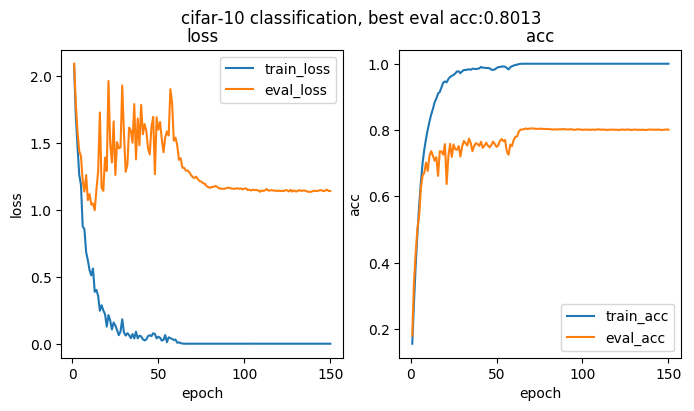

In [28]:
plot_loss_acc(mylogs)

### 模型推理